# Library & Install

In [ ]:
! pip install chembl_webresource_client
! pip install lazypredict
! pip install jcopml==1.1.1

In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
! unzip padel.zip

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
! conda install -c rdkit rdkit -y

In [ ]:
!pip install --upgrade scikit-learn==0.20.3

In [ ]:
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
from jcopml.plot import plot_missing_value

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Descriptors, Lipinski

import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import lazypredict
from lazypredict.Supervised import LazyRegressor, LazyClassifier

from tqdm import tqdm

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve

# Data

## Data Screening

In [9]:
target = new_client.target
target_query = target.search('PD-L1')
targets = pd.DataFrame.from_dict(target_query)
targets.head()

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Homo sapiens,Programmed cell death protein 1/Programmed cel...,22.0,False,CHEMBL4523993,"[{'accession': 'Q15116', 'component_descriptio...",PROTEIN COMPLEX,9606.0
1,[],Homo sapiens,Programmed cell death 1 ligand 1,21.0,False,CHEMBL3580522,"[{'accession': 'Q9NZQ7', 'component_descriptio...",SINGLE PROTEIN,9606.0
2,[],Mus musculus,Programmed cell death protein 1/Programmed cel...,20.0,False,CHEMBL4630756,"[{'accession': 'Q9EP73', 'component_descriptio...",PROTEIN COMPLEX,10090.0
3,[],Mus musculus,Programmed cell death 1 ligand 1,19.0,False,CHEMBL4523448,"[{'accession': 'Q9EP73', 'component_descriptio...",SINGLE PROTEIN,10090.0
4,[],None,PD-145,18.0,False,CHEMBL614845,[],CELL-LINE,NaN


In [10]:
def targetFilter(x):
    selected_target = targets.target_chembl_id[x]
    activity = new_client.activity
    res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
    df = pd.DataFrame.from_dict(res)
    return df

In [11]:
df_1 = targetFilter(0)
df_2 = targetFilter(1)
df_3 = targetFilter(2)
df_4 = targetFilter(3)
df_5 = targetFilter(4)
df_6 = targetFilter(5)
df_7 = targetFilter(6)

In [12]:
df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_2], ignore_index = True)
df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,18884511,[],CHEMBL4312946,Inhibition of human Fc-tagged PD1 N-terminal d...,B,None,None,BAO_0000190,...,Homo sapiens,Programmed cell death protein 1/Programmed cel...,9606,None,None,IC50,nM,UO_0000065,None,96.0
1,None,None,18884512,[],CHEMBL4312946,Inhibition of human Fc-tagged PD1 N-terminal d...,B,None,None,BAO_0000190,...,Homo sapiens,Programmed cell death protein 1/Programmed cel...,9606,None,None,IC50,nM,UO_0000065,None,2.5
2,None,None,18884513,[],CHEMBL4312946,Inhibition of human Fc-tagged PD1 N-terminal d...,B,None,None,BAO_0000190,...,Homo sapiens,Programmed cell death protein 1/Programmed cel...,9606,None,None,IC50,nM,UO_0000065,None,2.2
3,None,None,18884514,[],CHEMBL4312946,Inhibition of human Fc-tagged PD1 N-terminal d...,B,None,None,BAO_0000190,...,Homo sapiens,Programmed cell death protein 1/Programmed cel...,9606,None,None,IC50,nM,UO_0000065,None,25.0
4,None,None,18884515,[],CHEMBL4312946,Inhibition of human Fc-tagged PD1 N-terminal d...,B,None,None,BAO_0000190,...,Homo sapiens,Programmed cell death protein 1/Programmed cel...,9606,None,None,IC50,nM,UO_0000065,None,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25719084,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5390057,Inhibition of human PD-L1 (18 to 134 residues)...,B,None,None,BAO_0000190,...,Homo sapiens,Programmed cell death 1 ligand 1,9606,None,None,IC50,nM,UO_0000065,None,146.0
1559,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25719085,[],CHEMBL5390058,Inhibition of PD-L1 (unknown origin) by HTRF a...,B,None,None,BAO_0000190,...,Homo sapiens,Programmed cell death 1 ligand 1,9606,None,None,IC50,nM,UO_0000065,None,0.48
1560,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25719086,[],CHEMBL5390058,Inhibition of PD-L1 (unknown origin) by HTRF a...,B,None,None,BAO_0000190,...,Homo sapiens,Programmed cell death 1 ligand 1,9606,None,None,IC50,nM,UO_0000065,None,0.21
1561,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25719102,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5390068,Inhibition of human PD-L1 expressed in Escheri...,B,None,None,BAO_0000190,...,Homo sapiens,Programmed cell death 1 ligand 1,9606,None,None,IC50,nM,UO_0000065,None,22.0


In [13]:
# Filter data untuk Homo sapiens
filtered_data = df[df['target_organism'] == 'Homo sapiens']

# Tampilkan data hasil filter
filtered_data.head()


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,18884511,[],CHEMBL4312946,Inhibition of human Fc-tagged PD1 N-terminal d...,B,None,None,BAO_0000190,...,Homo sapiens,Programmed cell death protein 1/Programmed cel...,9606,None,None,IC50,nM,UO_0000065,None,96.0
1,None,None,18884512,[],CHEMBL4312946,Inhibition of human Fc-tagged PD1 N-terminal d...,B,None,None,BAO_0000190,...,Homo sapiens,Programmed cell death protein 1/Programmed cel...,9606,None,None,IC50,nM,UO_0000065,None,2.5
2,None,None,18884513,[],CHEMBL4312946,Inhibition of human Fc-tagged PD1 N-terminal d...,B,None,None,BAO_0000190,...,Homo sapiens,Programmed cell death protein 1/Programmed cel...,9606,None,None,IC50,nM,UO_0000065,None,2.2
3,None,None,18884514,[],CHEMBL4312946,Inhibition of human Fc-tagged PD1 N-terminal d...,B,None,None,BAO_0000190,...,Homo sapiens,Programmed cell death protein 1/Programmed cel...,9606,None,None,IC50,nM,UO_0000065,None,25.0
4,None,None,18884515,[],CHEMBL4312946,Inhibition of human Fc-tagged PD1 N-terminal d...,B,None,None,BAO_0000190,...,Homo sapiens,Programmed cell death protein 1/Programmed cel...,9606,None,None,IC50,nM,UO_0000065,None,3.0


In [14]:
# Memeriksa apakah semua nilai dalam kolom 'species' adalah 'Homo sapiens'
all_homo_sapiens = (filtered_data['target_organism'] == 'Homo sapiens').all()

# Menampilkan hasil
if all_homo_sapiens:
    print("Semua data adalah Homo sapiens.")
else:
    print("Tidak semua data adalah Homo sapiens.")


Semua data adalah Homo sapiens.


In [15]:
df.to_csv('00_crude_dataset_PD-L1.csv', index=False)

## Menghapus data yang hilang dan duplikat

In [16]:
df=pd.read_csv('/content/00_crude_dataset_PD-L1.csv')
df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,NaN,18884511,[],CHEMBL4312946,Inhibition of human Fc-tagged PD1 N-terminal d...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Programmed cell death protein 1/Programmed cel...,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,96.00
1,NaN,NaN,18884512,[],CHEMBL4312946,Inhibition of human Fc-tagged PD1 N-terminal d...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Programmed cell death protein 1/Programmed cel...,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,2.50
2,NaN,NaN,18884513,[],CHEMBL4312946,Inhibition of human Fc-tagged PD1 N-terminal d...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Programmed cell death protein 1/Programmed cel...,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,2.20
3,NaN,NaN,18884514,[],CHEMBL4312946,Inhibition of human Fc-tagged PD1 N-terminal d...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Programmed cell death protein 1/Programmed cel...,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,25.00
4,NaN,NaN,18884515,[],CHEMBL4312946,Inhibition of human Fc-tagged PD1 N-terminal d...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Programmed cell death protein 1/Programmed cel...,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,25719084,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5390057,Inhibition of human PD-L1 (18 to 134 residues)...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Programmed cell death 1 ligand 1,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,146.00
1559,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,25719085,[],CHEMBL5390058,Inhibition of PD-L1 (unknown origin) by HTRF a...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Programmed cell death 1 ligand 1,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,0.48
1560,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,25719086,[],CHEMBL5390058,Inhibition of PD-L1 (unknown origin) by HTRF a...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Programmed cell death 1 ligand 1,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,0.21
1561,"{'action_type': 'INHIBITOR', 'description': 'N...",NaN,25719102,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5390068,Inhibition of human PD-L1 expressed in Escheri...,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Programmed cell death 1 ligand 1,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,22.00


In [17]:
df_value = df[df.standard_value.notna()]
df_smile = df_value[df_value.canonical_smiles.notna()]
df_nr = df_smile.drop_duplicates(['canonical_smiles'])

In [18]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df_prep = df_nr[selection]

In [19]:
df_prep

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL4089730,COc1nc(OCc2cccc(-c3ccccc3)c2C)ccc1CNCCNC(C)=O,96.00
1,CHEMBL4516321,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1...,2.50
2,CHEMBL4436703,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...,2.20
3,CHEMBL4525587,COc1nc(OCc2cccc(-c3cccc(COc4ccc(CNCCNC(C)=O)c(...,25.00
4,CHEMBL4575618,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OC...,3.00
...,...,...,...
1492,CHEMBL5411746,CC(C)OC(=O)[C@@H](Cn1ccnc1)NC(=O)C1CCCN(C(=O)c...,63.00
1496,CHEMBL5398154,Cc1c(COc2cc(OCc3cncc(C#N)c3)c(CN3CCCC[C@H]3C(=...,0.48
1497,CHEMBL5413429,Cc1c(COc2cc(OCc3cccc(C#N)c3)c(CN3CCCC[C@H]3C(=...,0.21
1504,CHEMBL3577826,CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1...,19.38


In [20]:
df_prep.isna().sum()

,0
molecule_chembl_id,0
canonical_smiles,0
standard_value,0


In [21]:
df_prep.to_csv('dataset_prep_PD-L1.csv', index=False)

## Label

In [22]:
df_prep_label = pd.read_csv('/content/dataset_prep_PD-L1.csv')

* Molekul sangat aktif jika standard_value ≤ 10 (active)
* Molekul aktif sedang jika 10 < standard_value ≤ 50 (intermediate)
* Molekul kurang aktif jika standard_value > 50 (inactive)

In [23]:
bioactivity_threshold = []
for i in df_prep_label.standard_value:
    if float(i) > 50:  # Mengubah threshold untuk 'inactive'
        bioactivity_threshold.append("inactive")
    elif float(i) < 10:  # Mengubah threshold untuk 'active'
        bioactivity_threshold.append("active")
    else:
        bioactivity_threshold.append("intermediate")

In [24]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')

In [25]:
bioactivity_class = pd.DataFrame(bioactivity_class)
bioactivity_class

,class
0,inactive
1,active
2,active
3,intermediate
4,active
...,...
1317,inactive
1318,active
1319,active
1320,intermediate


In [26]:
df_label = pd.concat([df_prep_label, bioactivity_class],axis=1)
df_label.to_csv('label_PD-L1.csv', index=False)

In [27]:
! zip 'prep_PD-L1.csv'.zip *.csv

  adding: 00_crude_dataset_PD-L1.csv (deflated 94%)
  adding: dataset_prep_PD-L1.csv (deflated 83%)
  adding: label_PD-L1.csv (deflated 84%)


## Transform SMILES menjadi LIST

In [28]:
df_eda = pd.read_csv('/content/label_PD-L1.csv')
df_eda

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL4089730,COc1nc(OCc2cccc(-c3ccccc3)c2C)ccc1CNCCNC(C)=O,96.00,inactive
1,CHEMBL4516321,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1...,2.50,active
2,CHEMBL4436703,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...,2.20,active
3,CHEMBL4525587,COc1nc(OCc2cccc(-c3cccc(COc4ccc(CNCCNC(C)=O)c(...,25.00,intermediate
4,CHEMBL4575618,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OC...,3.00,active
...,...,...,...,...
1317,CHEMBL5411746,CC(C)OC(=O)[C@@H](Cn1ccnc1)NC(=O)C1CCCN(C(=O)c...,63.00,inactive
1318,CHEMBL5398154,Cc1c(COc2cc(OCc3cncc(C#N)c3)c(CN3CCCC[C@H]3C(=...,0.48,active
1319,CHEMBL5413429,Cc1c(COc2cc(OCc3cccc(C#N)c3)c(CN3CCCC[C@H]3C(=...,0.21,active
1320,CHEMBL3577826,CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1...,19.38,intermediate


In [29]:
df_eda = df_label
df_eda

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL4089730,COc1nc(OCc2cccc(-c3ccccc3)c2C)ccc1CNCCNC(C)=O,96.00,inactive
1,CHEMBL4516321,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1...,2.50,active
2,CHEMBL4436703,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...,2.20,active
3,CHEMBL4525587,COc1nc(OCc2cccc(-c3cccc(COc4ccc(CNCCNC(C)=O)c(...,25.00,intermediate
4,CHEMBL4575618,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OC...,3.00,active
...,...,...,...,...
1317,CHEMBL5411746,CC(C)OC(=O)[C@@H](Cn1ccnc1)NC(=O)C1CCCN(C(=O)c...,63.00,inactive
1318,CHEMBL5398154,Cc1c(COc2cc(OCc3cncc(C#N)c3)c(CN3CCCC[C@H]3C(=...,0.48,active
1319,CHEMBL5413429,Cc1c(COc2cc(OCc3cccc(C#N)c3)c(CN3CCCC[C@H]3C(=...,0.21,active
1320,CHEMBL3577826,CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1...,19.38,intermediate


In [30]:
df_no_smiles = df_eda.drop(columns='canonical_smiles')
df_no_smiles

,molecule_chembl_id,standard_value,class
0,CHEMBL4089730,96.00,inactive
1,CHEMBL4516321,2.50,active
2,CHEMBL4436703,2.20,active
3,CHEMBL4525587,25.00,intermediate
4,CHEMBL4575618,3.00,active
...,...,...,...
1317,CHEMBL5411746,63.00,inactive
1318,CHEMBL5398154,0.48,active
1319,CHEMBL5413429,0.21,active
1320,CHEMBL3577826,19.38,intermediate


In [31]:
smiles = []

for i in df_eda.canonical_smiles.tolist():
    cpd = str(i).split('.')
    cpd_longest = max(cpd, key = len)
    smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [32]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL4089730,96.00,inactive,COc1nc(OCc2cccc(-c3ccccc3)c2C)ccc1CNCCNC(C)=O
1,CHEMBL4516321,2.50,active,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1...
2,CHEMBL4436703,2.20,active,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...
3,CHEMBL4525587,25.00,intermediate,COc1nc(OCc2cccc(-c3cccc(COc4ccc(CNCCNC(C)=O)c(...
4,CHEMBL4575618,3.00,active,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OC...
...,...,...,...,...
1317,CHEMBL5411746,63.00,inactive,CC(C)OC(=O)[C@@H](Cn1ccnc1)NC(=O)C1CCCN(C(=O)c...
1318,CHEMBL5398154,0.48,active,Cc1c(COc2cc(OCc3cncc(C#N)c3)c(CN3CCCC[C@H]3C(=...
1319,CHEMBL5413429,0.21,active,Cc1c(COc2cc(OCc3cccc(C#N)c3)c(CN3CCCC[C@H]3C(=...
1320,CHEMBL3577826,19.38,intermediate,CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1...


## Menghitung Lipinski Deskriptor

In [33]:
pip install rdkit-pypi

     |████████████████████████████████| 29.2 MB 45.3 MB/s 


In [34]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import numpy as np
import pandas as pd

def lipinski(smiles, verbose=False):
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData = []
    for mol in moldata:
        if mol is not None:  # Pastikan molekul valid
            desc_MolWt = Descriptors.MolWt(mol)
            desc_MolLogP = Descriptors.MolLogP(mol)
            desc_NumHDonors = Lipinski.NumHDonors(mol)
            desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

            baseData.append([desc_MolWt, desc_MolLogP, desc_NumHDonors, desc_NumHAcceptors])
        else:
            baseData.append([None, None, None, None])  # Placeholder untuk molekul tidak valid

    columnNames = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)

    return descriptors


In [35]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,419.525,3.87032,2,5
1,534.660,5.62082,2,6
2,477.608,6.50462,1,5
3,684.838,4.38704,4,10
4,915.108,7.88804,4,12
...,...,...,...,...
1317,488.588,3.53890,1,6
1318,753.340,7.71322,2,9
1319,738.325,8.19372,1,8
1320,1689.980,-3.61923,22,21


## Menggabungkan antara dataset dengan deskriptor lipinski

In [36]:
df_combined = pd.concat([df_clean_smiles,df_lipinski], axis=1)
df_combined

,molecule_chembl_id,standard_value,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL4089730,96.00,inactive,COc1nc(OCc2cccc(-c3ccccc3)c2C)ccc1CNCCNC(C)=O,419.525,3.87032,2,5
1,CHEMBL4516321,2.50,active,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1...,534.660,5.62082,2,6
2,CHEMBL4436703,2.20,active,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...,477.608,6.50462,1,5
3,CHEMBL4525587,25.00,intermediate,COc1nc(OCc2cccc(-c3cccc(COc4ccc(CNCCNC(C)=O)c(...,684.838,4.38704,4,10
4,CHEMBL4575618,3.00,active,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OC...,915.108,7.88804,4,12
...,...,...,...,...,...,...,...,...
1317,CHEMBL5411746,63.00,inactive,CC(C)OC(=O)[C@@H](Cn1ccnc1)NC(=O)C1CCCN(C(=O)c...,488.588,3.53890,1,6
1318,CHEMBL5398154,0.48,active,Cc1c(COc2cc(OCc3cncc(C#N)c3)c(CN3CCCC[C@H]3C(=...,753.340,7.71322,2,9
1319,CHEMBL5413429,0.21,active,Cc1c(COc2cc(OCc3cccc(C#N)c3)c(CN3CCCC[C@H]3C(=...,738.325,8.19372,1,8
1320,CHEMBL3577826,19.38,intermediate,CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1...,1689.980,-3.61923,22,21


## Konversi IC50 menjadi pIC50

In [37]:
import numpy as np
import pandas as pd

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i * (10 ** -9)  # Konversi nM ke M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)  # Perbaikan: Tambahkan axis=1

    return x

def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
            i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1)  # Perbaikan: Tambahkan axis=1

    return x

In [38]:
df_norm = norm_value(df_combined)
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL4089730,inactive,COc1nc(OCc2cccc(-c3ccccc3)c2C)ccc1CNCCNC(C)=O,419.525,3.87032,2,5,7.017729
1,CHEMBL4516321,active,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1...,534.660,5.62082,2,6,8.602060
2,CHEMBL4436703,active,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...,477.608,6.50462,1,5,8.657577
3,CHEMBL4525587,intermediate,COc1nc(OCc2cccc(-c3cccc(COc4ccc(CNCCNC(C)=O)c(...,684.838,4.38704,4,10,7.602060
4,CHEMBL4575618,active,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OC...,915.108,7.88804,4,12,8.522879
...,...,...,...,...,...,...,...,...
1317,CHEMBL5411746,inactive,CC(C)OC(=O)[C@@H](Cn1ccnc1)NC(=O)C1CCCN(C(=O)c...,488.588,3.53890,1,6,7.200659
1318,CHEMBL5398154,active,Cc1c(COc2cc(OCc3cncc(C#N)c3)c(CN3CCCC[C@H]3C(=...,753.340,7.71322,2,9,9.318759
1319,CHEMBL5413429,active,Cc1c(COc2cc(OCc3cccc(C#N)c3)c(CN3CCCC[C@H]3C(=...,738.325,8.19372,1,8,9.677781
1320,CHEMBL3577826,intermediate,CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1...,1689.980,-3.61923,22,21,7.712646


In [39]:
df_final.to_csv('label3class_PD-L.csv', index=False)

## Menghapus kelas 'intermediet class'

In [40]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL4089730,inactive,COc1nc(OCc2cccc(-c3ccccc3)c2C)ccc1CNCCNC(C)=O,419.525,3.87032,2,5,7.017729
1,CHEMBL4516321,active,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1...,534.660,5.62082,2,6,8.602060
2,CHEMBL4436703,active,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...,477.608,6.50462,1,5,8.657577
4,CHEMBL4575618,active,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OC...,915.108,7.88804,4,12,8.522879
5,CHEMBL4528795,active,CCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OCc5cncc(...,801.004,9.65564,2,10,8.420216
...,...,...,...,...,...,...,...,...
1309,CHEMBL4776700,active,Cn1cnc(S(=O)(=O)N2CCCC3=C[C@H]4C[C@H](CN5CCCC[...,376.526,2.00380,0,5,9.000000
1312,CHEMBL5171101,active,CCCC[C@H]1C(=O)N(C)[C@@H](CCCC)C(=O)N[C@@H](C)...,1866.139,-3.56110,19,23,8.987163
1317,CHEMBL5411746,inactive,CC(C)OC(=O)[C@@H](Cn1ccnc1)NC(=O)C1CCCN(C(=O)c...,488.588,3.53890,1,6,7.200659
1318,CHEMBL5398154,active,Cc1c(COc2cc(OCc3cncc(C#N)c3)c(CN3CCCC[C@H]3C(=...,753.340,7.71322,2,9,9.318759


In [41]:
df_2class.isna().sum()

,0
molecule_chembl_id,0
class,0
canonical_smiles,0
MW,0
LogP,0
NumHDonors,0
NumHAcceptors,0
pIC50,0


In [42]:
df_2class.to_csv('label2class_PD-L1.csv', index=False)

# PLOTTING (EDA)

## Plot frekuensi dari dua kelas bioaktifitas

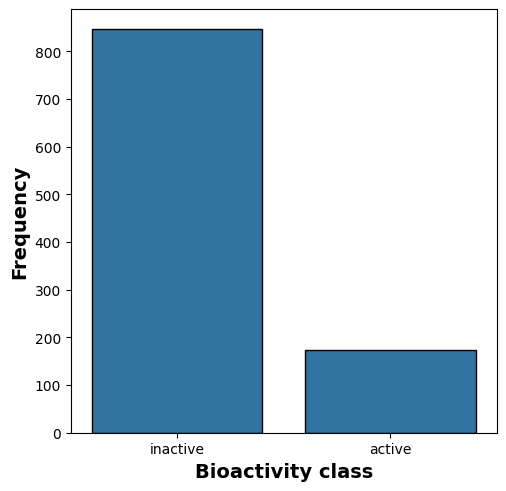

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

## Scatter plot MW vs LogP

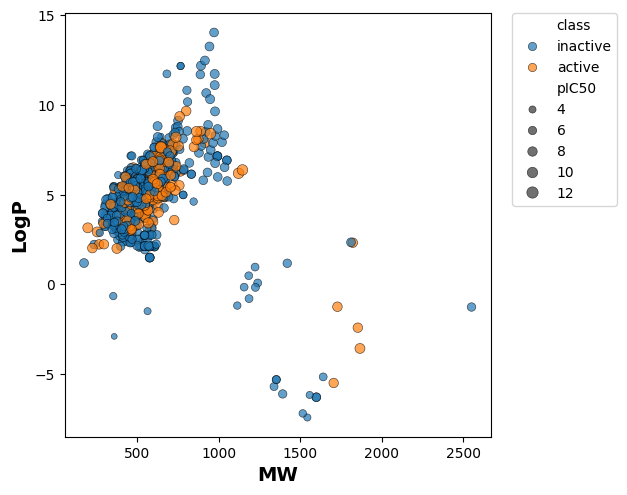

In [44]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

## pIC50 Value Boxplots

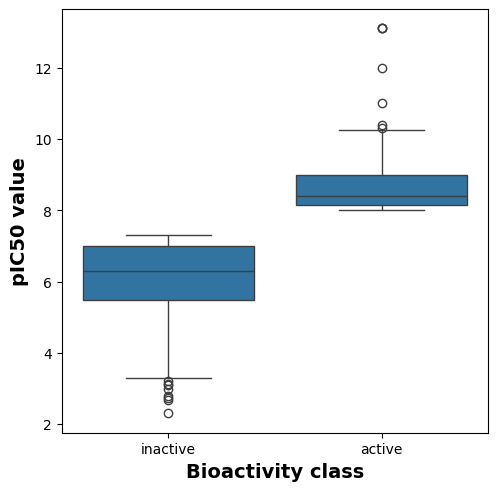

In [45]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

## Statistical analysis | Mann-Whitney U Test

In [46]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [47]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,147204.0,3.021447e-96,0.05,Different distribution (reject H0)


## MW

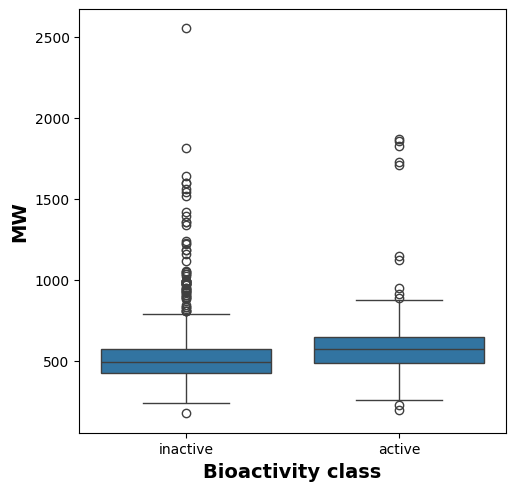

In [48]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [49]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,94614.0,2.900858e-09,0.05,Different distribution (reject H0)


## LogP

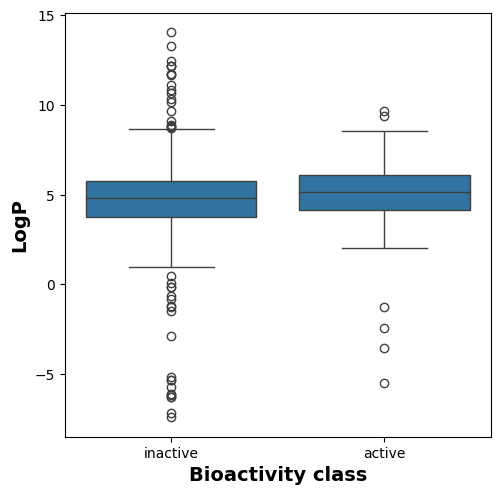

In [50]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

## NumHDonors

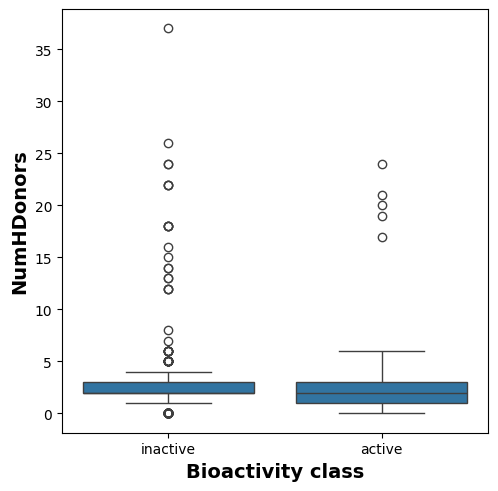

In [51]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [52]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,79463.0,0.0856,0.05,Same distribution (fail to reject H0)


## NumHAcceptors

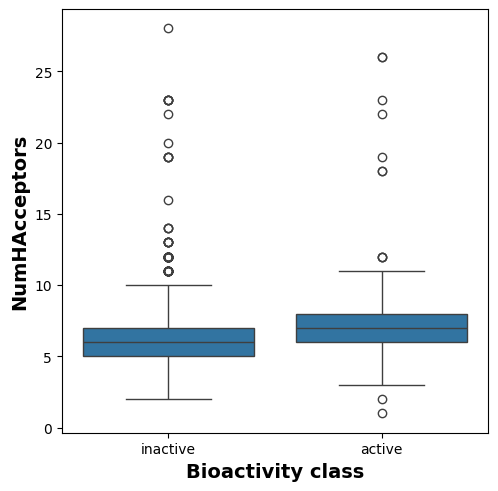

In [53]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [54]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,87558.5,0.000066,0.05,Different distribution (reject H0)


# Fingerprint Generation

## Padel Descriptor

In [55]:
selection = ['canonical_smiles','molecule_chembl_id']
df_selection = df_2class[selection]
df_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

! cat molecule.smi | head -5

COc1nc(OCc2cccc(-c3ccccc3)c2C)ccc1CNCCNC(C)=O	CHEMBL4089730
CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cncc(C#N)c1	CHEMBL4516321
CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cncc(C#N)c1	CHEMBL4436703
CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OCc5cncc(C#N)c5)c(CNCCNC(C)=O)cc4C)c3C)c2C)cc1OCc1cncc(C#N)c1	CHEMBL4575618
CCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OCc5cncc(C#N)c5)c(CNCC)cc4C)c3C)c2C)cc1OCc1cncc(C#N)c1	CHEMBL4528795


In [56]:
! cat molecule.smi | wc -l

1020


In [57]:
!cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [ ]:
! bash padel.sh

## Menggabungkan Fingerprint dan dataframe class

In [59]:
df_X = pd.read_csv('descriptors_output.csv')

In [60]:
df_X = df_X.drop(columns=['Name'])
df_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1016,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1017,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1018,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [61]:
df_2class_prep = pd.read_csv('/content/label2class_PD-L1.csv')

In [62]:
selection1= ['pIC50', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors']
df_Y = df_2class_prep [selection1]
df_Y

,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,7.017729,419.525,3.87032,2,5
1,8.602060,534.660,5.62082,2,6
2,8.657577,477.608,6.50462,1,5
3,8.522879,915.108,7.88804,4,12
4,8.420216,801.004,9.65564,2,10
...,...,...,...,...,...
1015,9.000000,376.526,2.00380,0,5
1016,8.987163,1866.139,-3.56110,19,23
1017,7.200659,488.588,3.53890,1,6
1018,9.318759,753.340,7.71322,2,9


In [63]:
dataset = pd.concat([df_X,df_Y], axis=1)
dataset

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,7.017729,419.525,3.87032,2,5
1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,8.602060,534.660,5.62082,2,6
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,8.657577,477.608,6.50462,1,5
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,8.522879,915.108,7.88804,4,12
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,8.420216,801.004,9.65564,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,9.000000,376.526,2.00380,0,5
1016,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,8.987163,1866.139,-3.56110,19,23
1017,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,7.200659,488.588,3.53890,1,6
1018,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,9.318759,753.340,7.71322,2,9


In [64]:
dataset.isna().sum()

,0
PubchemFP0,0
PubchemFP1,0
PubchemFP2,0
PubchemFP3,0
PubchemFP4,0
...,...
pIC50,0
MW,0
LogP,0
NumHDonors,0


In [65]:
dataset=dataset.dropna()
dataset

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,7.017729,419.525,3.87032,2,5
1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,8.602060,534.660,5.62082,2,6
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,8.657577,477.608,6.50462,1,5
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,8.522879,915.108,7.88804,4,12
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,8.420216,801.004,9.65564,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,9.000000,376.526,2.00380,0,5
1016,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,8.987163,1866.139,-3.56110,19,23
1017,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,7.200659,488.588,3.53890,1,6
1018,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,9.318759,753.340,7.71322,2,9


## Mengecek low variance

In [66]:
selection2= ['pIC50', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors']
lipinski = dataset [selection2]
lipinski.head()

,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,7.017729,419.525,3.87032,2,5
1,8.602060,534.660,5.62082,2,6
2,8.657577,477.608,6.50462,1,5
3,8.522879,915.108,7.88804,4,12
4,8.420216,801.004,9.65564,2,10


In [67]:
variance = dataset.drop(columns= ['pIC50',  'MW', 'LogP', 'NumHDonors', 'NumHAcceptors'], axis=1)
variance.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [68]:
fix = pd.concat([variance,lipinski], axis=1)
fix.to_csv('dataset_modelvariance_PD-L1.csv', index=False)

In [69]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
variance = selection.fit_transform(variance)
variance = pd.DataFrame(variance)
variance.isna().sum()

,0
0,0
1,0
2,0
3,0
4,0
...,...
176,0
177,0
178,0
179,0


In [70]:
variance.columns = variance.columns.astype(str)
fix = pd.concat([variance,lipinski], axis=1)
fix

,0,1,2,3,4,5,6,7,8,9,...,176,177,178,179,180,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,7.017729,419.525,3.87032,2,5
1,1,1,1,0,0,0,0,0,1,1,...,1,1,1,0,0,8.602060,534.660,5.62082,2,6
2,0,0,0,0,0,0,0,0,1,1,...,1,1,1,0,0,8.657577,477.608,6.50462,1,5
3,1,1,1,1,0,0,0,0,1,1,...,1,1,1,0,0,8.522879,915.108,7.88804,4,12
4,1,1,1,1,0,0,0,0,1,1,...,1,1,1,0,0,8.420216,801.004,9.65564,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,0,1,1,1,1,0,0,0,1,1,...,1,1,1,0,0,9.000000,376.526,2.00380,0,5
1016,1,0,1,1,0,1,1,1,1,1,...,0,0,0,0,0,8.987163,1866.139,-3.56110,19,23
1017,1,1,1,1,1,0,0,0,1,1,...,1,1,1,0,0,7.200659,488.588,3.53890,1,6
1018,0,1,1,1,0,1,1,1,1,1,...,0,0,0,1,0,9.318759,753.340,7.71322,2,9


In [71]:
fix=fix.dropna()
fix

,0,1,2,3,4,5,6,7,8,9,...,176,177,178,179,180,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,7.017729,419.525,3.87032,2,5
1,1,1,1,0,0,0,0,0,1,1,...,1,1,1,0,0,8.602060,534.660,5.62082,2,6
2,0,0,0,0,0,0,0,0,1,1,...,1,1,1,0,0,8.657577,477.608,6.50462,1,5
3,1,1,1,1,0,0,0,0,1,1,...,1,1,1,0,0,8.522879,915.108,7.88804,4,12
4,1,1,1,1,0,0,0,0,1,1,...,1,1,1,0,0,8.420216,801.004,9.65564,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,0,1,1,1,1,0,0,0,1,1,...,1,1,1,0,0,9.000000,376.526,2.00380,0,5
1016,1,0,1,1,0,1,1,1,1,1,...,0,0,0,0,0,8.987163,1866.139,-3.56110,19,23
1017,1,1,1,1,1,0,0,0,1,1,...,1,1,1,0,0,7.200659,488.588,3.53890,1,6
1018,0,1,1,1,0,1,1,1,1,1,...,0,0,0,1,0,9.318759,753.340,7.71322,2,9


In [72]:
fix.to_csv('dataset_model_PD-L1.csv', index=False)

# Klasifikasi Random Forest

**dataset 1 (lipinsky)**

In [188]:
df_PDL1 = pd.read_csv('/content/label2class_PD-L1.csv')
df_PDL1

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL4089730,inactive,COc1nc(OCc2cccc(-c3ccccc3)c2C)ccc1CNCCNC(C)=O,419.53,3.87,2,5,7.02
1,CHEMBL4516321,active,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1...,534.66,5.62,2,6,8.60
2,CHEMBL4436703,active,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...,477.61,6.50,1,5,8.66
3,CHEMBL4575618,active,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OC...,915.11,7.89,4,12,8.52
4,CHEMBL4528795,active,CCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OCc5cncc(...,801.00,9.66,2,10,8.42
...,...,...,...,...,...,...,...,...
1015,CHEMBL4776700,active,Cn1cnc(S(=O)(=O)N2CCCC3=C[C@H]4C[C@H](CN5CCCC[...,376.53,2.00,0,5,9.00
1016,CHEMBL5171101,active,CCCC[C@H]1C(=O)N(C)[C@@H](CCCC)C(=O)N[C@@H](C)...,1866.14,-3.56,19,23,8.99
1017,CHEMBL5411746,inactive,CC(C)OC(=O)[C@@H](Cn1ccnc1)NC(=O)C1CCCN(C(=O)c...,488.59,3.54,1,6,7.20
1018,CHEMBL5398154,active,Cc1c(COc2cc(OCc3cncc(C#N)c3)c(CN3CCCC[C@H]3C(=...,753.34,7.71,2,9,9.32


**Melakukan transformasi class menjadi numeric ordinal**

In [189]:
# Mapping kelas kategori (class) ke nilai numerik (0,1)
mapping = {'active': 0, 'inactive': 1}
df_PDL1['class_numeric'] = df_PDL1['class'].map(mapping)

df_PDL1

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50,class_numeric
0,CHEMBL4089730,inactive,COc1nc(OCc2cccc(-c3ccccc3)c2C)ccc1CNCCNC(C)=O,419.53,3.87,2,5,7.02,1
1,CHEMBL4516321,active,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1...,534.66,5.62,2,6,8.60,0
2,CHEMBL4436703,active,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...,477.61,6.50,1,5,8.66,0
3,CHEMBL4575618,active,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OC...,915.11,7.89,4,12,8.52,0
4,CHEMBL4528795,active,CCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OCc5cncc(...,801.00,9.66,2,10,8.42,0
...,...,...,...,...,...,...,...,...,...
1015,CHEMBL4776700,active,Cn1cnc(S(=O)(=O)N2CCCC3=C[C@H]4C[C@H](CN5CCCC[...,376.53,2.00,0,5,9.00,0
1016,CHEMBL5171101,active,CCCC[C@H]1C(=O)N(C)[C@@H](CCCC)C(=O)N[C@@H](C)...,1866.14,-3.56,19,23,8.99,0
1017,CHEMBL5411746,inactive,CC(C)OC(=O)[C@@H](Cn1ccnc1)NC(=O)C1CCCN(C(=O)c...,488.59,3.54,1,6,7.20,1
1018,CHEMBL5398154,active,Cc1c(COc2cc(OCc3cncc(C#N)c3)c(CN3CCCC[C@H]3C(=...,753.34,7.71,2,9,9.32,0


**dataset 2 (finger print)**

In [190]:
df_fp = pd.read_csv('/content/dataset_model_PD-L1.csv')
df_fp = df_fp.drop(columns='pIC50')
df_fp

,0,1,2,3,4,5,6,7,8,9,...,175,176,177,178,179,180,MW,LogP,NumHDonors,NumHAcceptors
0,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,419.53,3.87,2,5
1,1,1,1,0,0,0,0,0,1,1,...,0,1,1,1,0,0,534.66,5.62,2,6
2,0,0,0,0,0,0,0,0,1,1,...,0,1,1,1,0,0,477.61,6.50,1,5
3,1,1,1,1,0,0,0,0,1,1,...,0,1,1,1,0,0,915.11,7.89,4,12
4,1,1,1,1,0,0,0,0,1,1,...,0,1,1,1,0,0,801.00,9.66,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,0,1,1,1,1,0,0,0,1,1,...,0,1,1,1,0,0,376.53,2.00,0,5
1016,1,0,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,1866.14,-3.56,19,23
1017,1,1,1,1,1,0,0,0,1,1,...,0,1,1,1,0,0,488.59,3.54,1,6
1018,0,1,1,1,0,1,1,1,1,1,...,0,0,0,0,1,0,753.34,7.71,2,9


**dataset 3 (combined)**

In [191]:
df = pd.concat([df_PDL1,df_fp], axis=1)
df.head()

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50,class_numeric,0,...,175,176,177,178,179,180,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL4089730,inactive,COc1nc(OCc2cccc(-c3ccccc3)c2C)ccc1CNCCNC(C)=O,419.53,3.87,2,5,7.02,1,0,...,0,0,1,0,0,0,419.53,3.87,2,5
1,CHEMBL4516321,active,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1...,534.66,5.62,2,6,8.60,0,1,...,0,1,1,1,0,0,534.66,5.62,2,6
2,CHEMBL4436703,active,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...,477.61,6.50,1,5,8.66,0,0,...,0,1,1,1,0,0,477.61,6.50,1,5
3,CHEMBL4575618,active,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OC...,915.11,7.89,4,12,8.52,0,1,...,0,1,1,1,0,0,915.11,7.89,4,12
4,CHEMBL4528795,active,CCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OCc5cncc(...,801.00,9.66,2,10,8.42,0,1,...,0,1,1,1,0,0,801.00,9.66,2,10


In [192]:
X = df.drop(columns=['molecule_chembl_id', 'canonical_smiles', 'class', 'class_numeric', 'MW','LogP', 'NumHDonors', 'NumHAcceptors', 'pIC50']) # Changed 'class numeric' to 'class_numeric'
X = X.astype(float)
X

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,...,0.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,...,0.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00
3,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,...,0.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00
4,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,...,0.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,...,0.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00
1016,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1017,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,...,0.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00
1018,0.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [193]:
y = df['class_numeric']
y

,class_numeric
0,1
1,0
2,0
3,0
4,0
...,...
1015,0
1016,0
1017,1
1018,0


In [194]:
y.value_counts()

,count
class_numeric,
1,846
0,174


In [195]:
X.shape, y.shape

((1020, 181), (1020,))

In [196]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [197]:
X_resampled

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,...,0.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,...,0.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00
3,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,...,0.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00
4,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,...,0.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00
1688,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,...,0.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00
1689,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,...,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
1690,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00


In [198]:
y_resampled.value_counts()

,count
class_numeric,
1,846
0,846


### Split Data

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [200]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1353, 181), (339, 181), (1353,), (339,))

* X_train: (1353, 181) -> Fitur training
* y_train: (1353,) -> Target training
* X_test: (339, 181) -> Fitur testing
* y_test: (339,) -> Target testing

### Random forest (tanpa pipeline)

In [201]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
accuracy = rfc.score(X_test, y_test)
print(accuracy)

0.9292035398230089


### Pipeline

In [202]:
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='mean')),
    ("scaler", MinMaxScaler())
])
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("ordinal_encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

numeric = []
categoric = [col for col in X_train.columns if col not in numeric]

preprocessor = ColumnTransformer([
    ("numeric", numerical_pipeline, numeric),
    ("categoric", categorical_pipeline,categoric)
])


In [203]:
pipeline = Pipeline([
    ("prep", preprocessor),
    ("classifier", RandomForestClassifier())
])

In [204]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  []),
                                                 ('categoric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['0', '1', '2', '3', '4', '5',
                                                   '6', '7', '8', '9', '10',
                                                   '11', '12', '13', '14', '15',
                                                   '16', '17', '18', '19', '20',
                                                   '21', '22', '23', '24', '25',
                                                   '26', '27', '28', '29', ...])])),
                ('classifier', RandomForestClassifier())])

### Hyperparameter Tuning

In [205]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [5, 10, 15, 20],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
}

model = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, return_train_score=True)
model.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         []),
                                                                        ('categoric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal_encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['0',
                                                                          '1'...
                                                                          '4',
                                                                          '5',
                                                                          '6',
                                                                          '7',
                                                                          '8',
                                                                          '9',
                                                                          '10',
                                                                          '11',
                                                                          '12',
                                                                          '13',
                                                                          '14',
                                                                          '15',
                                                                          '16',
                                                                          '17',
                                                                          '18',
                                                                          '19',
                                                                          '20',
                                                                          '21',
                                                                          '22',
                                                                          '23',
                                                                          '24',
                                                                          '25',
                                                                          '26',
                                                                          '27',
                                                                          '28',
                                                                          '29', ...])])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [5, 10, 15, 20]},
             return_train_score=True, verbose=1)

In [206]:
# evaluation
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

{'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 15}
0.991130820399113 0.9371682383490502 0.9351032448377581


**Parameter terpilih :**


*   n estimator : 15
*   minimal sampel split : 2
*   Kedalaman : none

### Predict

In [207]:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

In [208]:
y_pred_best = model.predict(X_test)
y_pred_best_proba = model.predict_proba(X_test)[:, 1]

In [209]:
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred_best))


Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       153
           1       0.99      0.89      0.94       186

    accuracy                           0.94       339
   macro avg       0.94      0.94      0.93       339
weighted avg       0.94      0.94      0.94       339



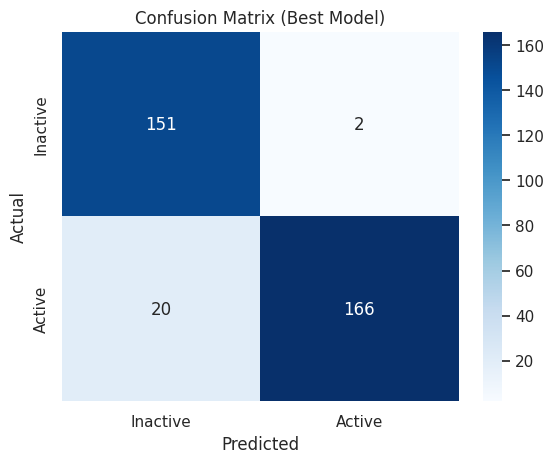

In [210]:
# Confusion Matrix untuk model terbaik
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', xticklabels=['Inactive', 'Active'], yticklabels=['Inactive', 'Active'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Best Model)')
plt.show()

In [211]:
# ROC-AUC untuk model terbaik
roc_auc_best = roc_auc_score(y_test, y_pred_best_proba)
print("\nROC-AUC Score (Best Model):", roc_auc_best)


ROC-AUC Score (Best Model): 0.988720219270504


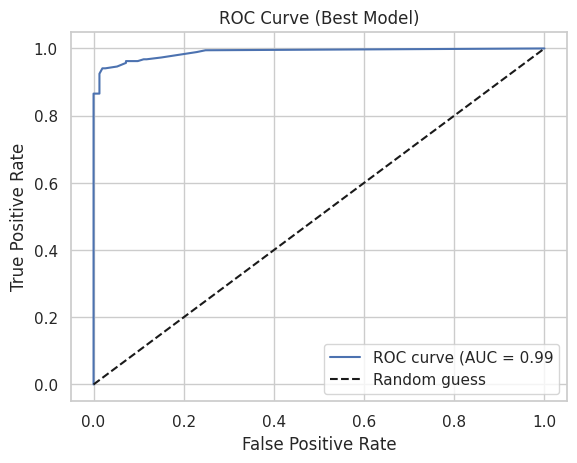

In [212]:
# plot ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_best_proba)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_best:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Best Model)')
plt.legend()
plt.show()

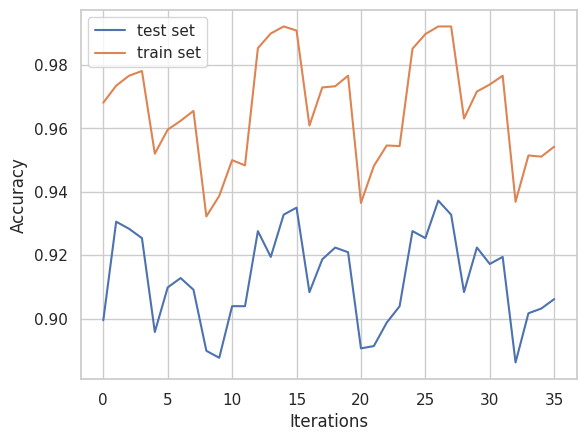

In [213]:
plt.plot(model.cv_results_['mean_test_score'])
plt.plot(model.cv_results_['mean_train_score'])
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend(['test set', 'train set'], loc='upper left')
plt.show()

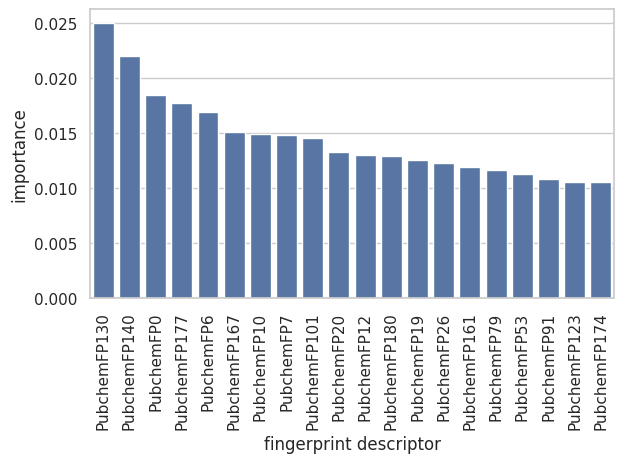

In [214]:
# get importance with Random Forest
importance = model.best_estimator_.named_steps['classifier'].feature_importances_
fp = sorted(range(len(importance)), key=lambda i: importance[i], reverse=True)[:20]
imp_values = sorted(importance, reverse=True)[:20]
fp = ['PubchemFP'+str(i) for i in fp]
imp_values
fake = pd.DataFrame({'ind': fp, 'importance__': imp_values})
ax = sns.barplot(x = 'ind', y = 'importance__', data = fake)
ax.set(xlabel='fingerprint descriptor', ylabel='importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Lazy Predict

In [215]:
from lazypredict.Supervised import LazyRegressor
reg = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
train,test = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:40<00:00,  1.03it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 1353, number of used features: 181
[LightGBM] [Info] Start training from score 0.487805


In [216]:
train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.56,0.80,0.23,1.43
BaggingRegressor,0.55,0.79,0.23,0.33
HistGradientBoostingRegressor,0.47,0.75,0.25,1.24
SVR,0.41,0.72,0.26,0.28
ExtraTreesRegressor,0.39,0.72,0.26,1.85
MLPRegressor,0.39,0.72,0.27,2.31
LGBMRegressor,0.36,0.70,0.27,0.26
ExtraTreeRegressor,0.35,0.70,0.27,0.10
NuSVR,0.35,0.70,0.27,1.25


In [217]:
test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.56,0.80,0.23,1.43
BaggingRegressor,0.55,0.79,0.23,0.33
HistGradientBoostingRegressor,0.47,0.75,0.25,1.24
SVR,0.41,0.72,0.26,0.28
ExtraTreesRegressor,0.39,0.72,0.26,1.85
MLPRegressor,0.39,0.72,0.27,2.31
LGBMRegressor,0.36,0.70,0.27,0.26
ExtraTreeRegressor,0.35,0.70,0.27,0.10
NuSVR,0.35,0.70,0.27,1.25


[(0.0, 1.0)]

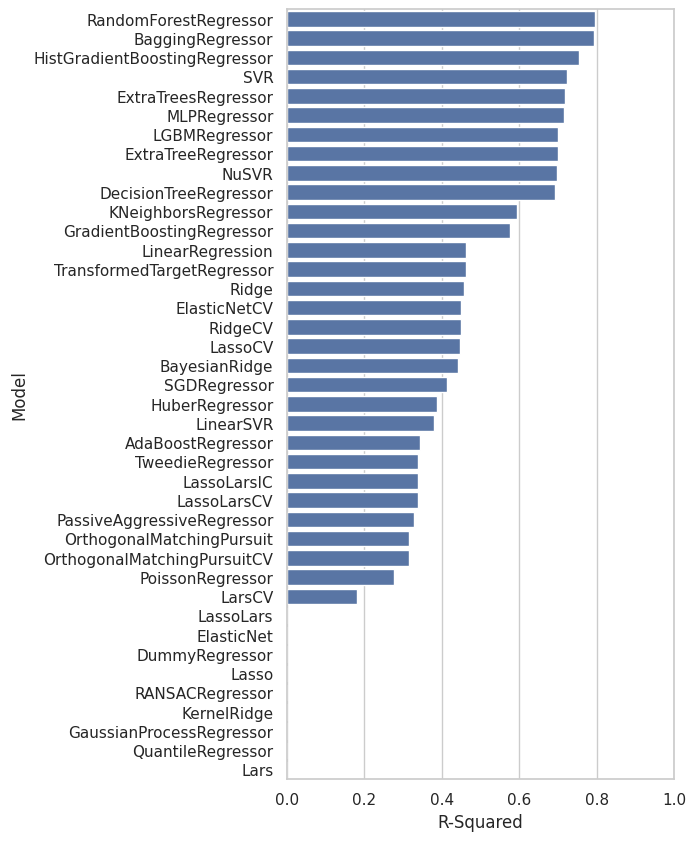

In [218]:
# Bar plot of R-squared values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=train.index, x="R-Squared", data=train)
ax.set(xlim=(0, 1))
#plt.savefig('plot_benchmark_RSquared.png', dpi=800)

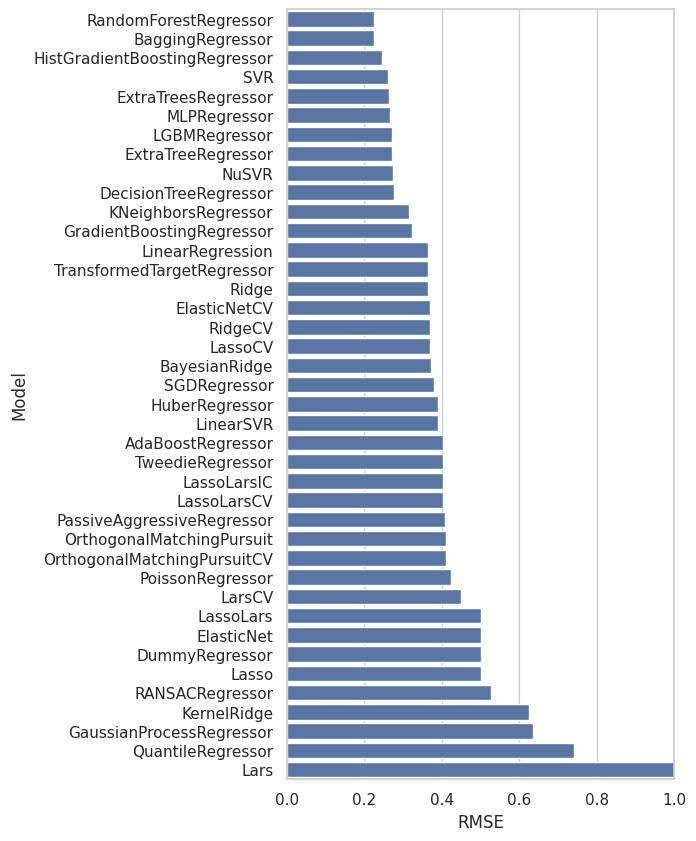

In [219]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=train.index, x="RMSE", data=train)
ax.set(xlim=(0, 1))
plt.savefig('plot_benchmark_RMSE.png', dpi=600) # Corrected line

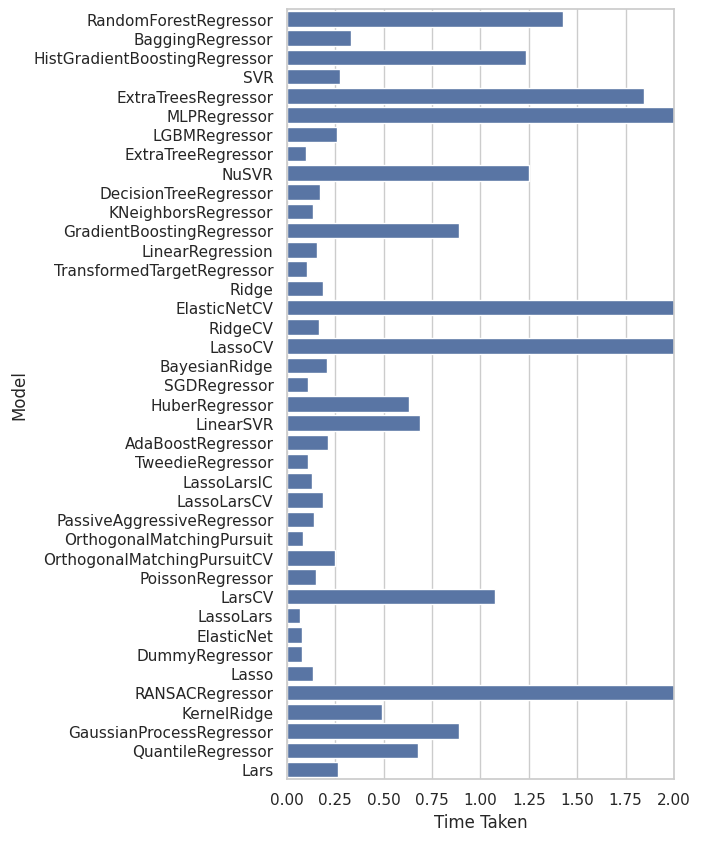

In [220]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=train.index, x="Time Taken", data=train)
ax.set(xlim=(0, 2))
plt.savefig('plot_benchmark_calculation_time.pdf')

# A. Import

In [140]:
import pandas as pd
import numpy as np
import seaborn as sn
#---------------------- RDKit packages
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
#------------------- Fingerprint
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools

#------------------- progress bar
from tqdm import tqdm
#------------------- hide warning
import warnings
warnings.filterwarnings('ignore')

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


# B. Input Dataset & Seleksi Kolom SMILES

In [141]:
dataset = pd.read_csv('/content/label2class_PD-L1.csv')

selection = ['canonical_smiles','pIC50']
dataset = dataset[selection]
dataset.to_csv('input_deskriptor.csv', index=False)

In [142]:
dataset = pd.read_csv('input_deskriptor.csv')
dataset.head()

,canonical_smiles,pIC50
0,COc1nc(OCc2cccc(-c3ccccc3)c2C)ccc1CNCCNC(C)=O,7.02
1,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1...,8.60
2,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...,8.66
3,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OC...,8.52
4,CCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OCc5cncc(...,8.42


# C. Menambahkan Kolom Struktur 2D pada Dataframe

In [143]:
# Include 2D structure of molecules
# https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/PandasTools.py
PandasTools.AddMoleculeColumnToFrame(dataset,'canonical_smiles', 'Structure')
dataset

Failed to patch pandas - unable to change molecule rendering


,canonical_smiles,pIC50,Structure
0,COc1nc(OCc2cccc(-c3ccccc3)c2C)ccc1CNCCNC(C)=O,7.02,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b68b1b0>
1,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1...,8.60,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b68b530>
2,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...,8.66,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b68b450>
3,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OC...,8.52,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b68b4c0>
4,CCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OCc5cncc(...,8.42,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b68b3e0>
...,...,...,...
1015,Cn1cnc(S(=O)(=O)N2CCCC3=C[C@H]4C[C@H](CN5CCCC[...,9.00,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b6d7990>
1016,CCCC[C@H]1C(=O)N(C)[C@@H](CCCC)C(=O)N[C@@H](C)...,8.99,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b6d7a00>
1017,CC(C)OC(=O)[C@@H](Cn1ccnc1)NC(=O)C1CCCN(C(=O)c...,7.20,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b6d7a70>
1018,Cc1c(COc2cc(OCc3cncc(C#N)c3)c(CN3CCCC[C@H]3C(=...,9.32,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b6d7ae0>


# D. Visualisasi SD Bentuk Grid

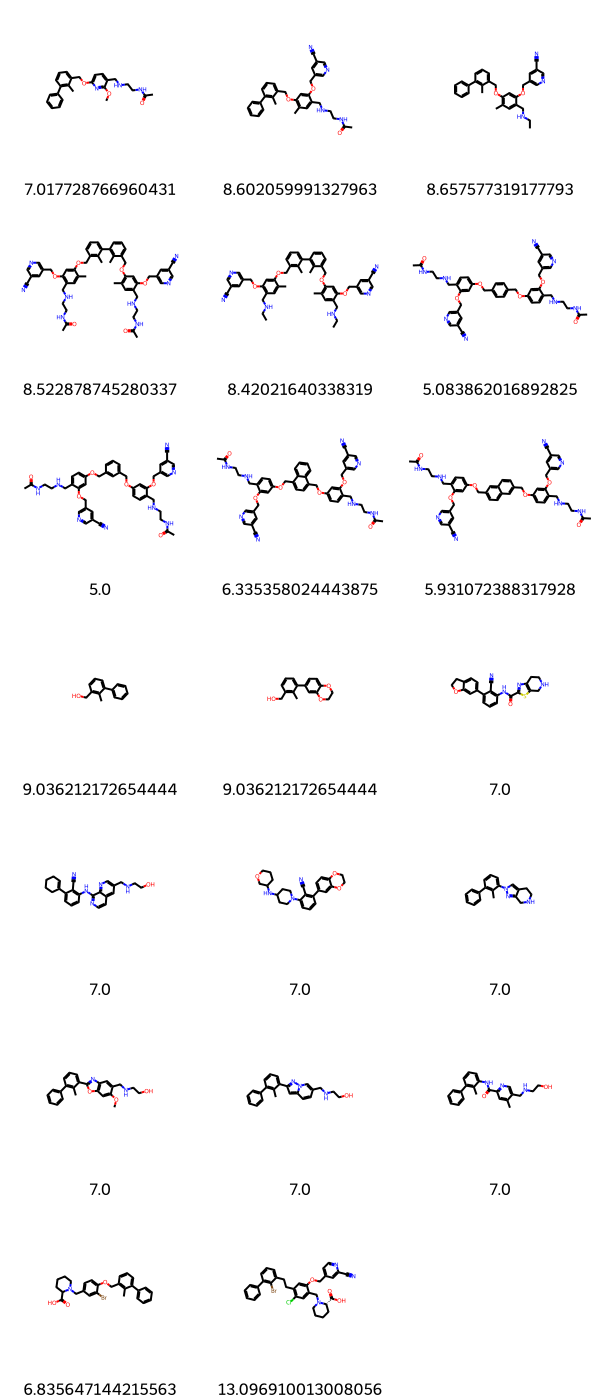

In [144]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([x for x in dataset["Structure"]][:20], maxMols=100,legends=[str(x) for x in dataset.pIC50], subImgSize=(200,200))

# E. Generate Fingerprint

## 1. MACC-Keys

In [145]:
MACC = MACCSkeys.GenMACCSKeys(dataset.Structure[0])
print("Array bits: /n", np.array(MACC))
print("Jumlah bits yang digunakan: ",len(MACC))
print("Ukuran bits MACC: ",np.array(MACC).shape)
print("Index fingerprint yang aktif: \n",tuple(MACC.GetOnBits()))
print("Jumlah fingerprint yang aktif: ",len(MACC.GetOnBits()))

Array bits: /n [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
Jumlah bits yang digunakan:  167
Ukuran bits MACC:  (167,)
Index fingerprint yang aktif: 
 (54, 62, 65, 79, 80, 82, 86, 89, 91, 92, 93, 97, 98, 100, 104, 108, 109, 110, 111, 113, 116, 117, 118, 121, 125, 126, 127, 129, 131, 137, 138, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165)
Jumlah fingerprint yang aktif:  54


## 2. Avalon

In [146]:
Avalon = pyAvalonTools.GetAvalonFP(dataset.Structure[0], nBits=512)
print("Array bits: /n", np.array(Avalon))
print("Jumlah bits yang digunakan: ",len(Avalon))
print("Ukuran bits MACC: ",np.array(Avalon).shape)
print("Index fingerprint yang aktif: \n",tuple(Avalon.GetOnBits()))
print("Jumlah fingerprint yang aktif: ",len(Avalon.GetOnBits()))

Array bits: /n [0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0
 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1
 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1
 0 0 1 0 0

## 3. Atom-Pair

In [147]:
At_P = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(dataset.Structure[0], nBits=512)
print("Array bits: /n", np.array(At_P))
print("Jumlah bits yang digunakan: ",len(At_P))
print("Ukuran bits Atom Pairs: ",np.array(At_P).shape)
print("Index fingerprint yang aktif: \n",tuple(At_P.GetOnBits()))
print("Jumlah fingerprint yang aktif: ",len(At_P.GetOnBits()))

Array bits: /n [1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1
 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1
 1 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0
 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0
 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0
 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1
 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1
 1 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0
 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0
 0 0 0 1 1

## 4. Topologi-Torsi

In [148]:
ToTo = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(dataset.Structure[0], nBits=512)
print("Array bits: /n", np.array(ToTo))
print("Jumlah bits yang digunakan: ",len(ToTo))
print("Ukuran bits Topologi-Torsi: ",np.array(ToTo).shape)
print("Index fingerprint yang aktif: \n",tuple(ToTo.GetOnBits()))
print("Jumlah fingerprint yang aktif: ",len(ToTo.GetOnBits()))

Array bits: /n [1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0

## 5. Morgan Circular

In [149]:
onbits = {}
morgan = AllChem.GetMorganFingerprintAsBitVect(dataset.Structure[0], 2, nBits=512, bitInfo=onbits)
print("Array bits: /n", np.array(morgan))
print("Jumlah bits yang digunakan: ",len(morgan))
print("Ukuran bits MORGAN: ",np.array(morgan).shape)
print("Index fingerprint yang aktif: \n",tuple(morgan.GetOnBits()))
print("Jumlah fingerprint yang aktif: ",len(morgan.GetOnBits()))

Array bits: /n [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0
 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1

Visual salah satu finger print yanga aktif pada Bits: 


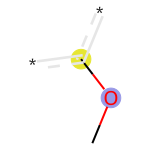

In [150]:
# Get the available bit IDs from the onbits dictionary
available_bit_ids = list(onbits.keys())

# Choose a bit ID that is present in the available_bit_ids
bit_id_to_draw = available_bit_ids[0]  # For example, choose the first available bit ID

# Draw the Morgan bit using the chosen bit ID
print("Visual salah satu finger print yanga aktif pada Bits: ")
Draw.DrawMorganBit(dataset.Structure[0], bit_id_to_draw, onbits)

In [151]:
# print("Visual salah satu finger print yanga aktif pada Bits: ")
# Draw.DrawMorganBit(dataset.Structure[0], 152, onbits)

Visual semua fingerprint yang aktif pada Bits: 


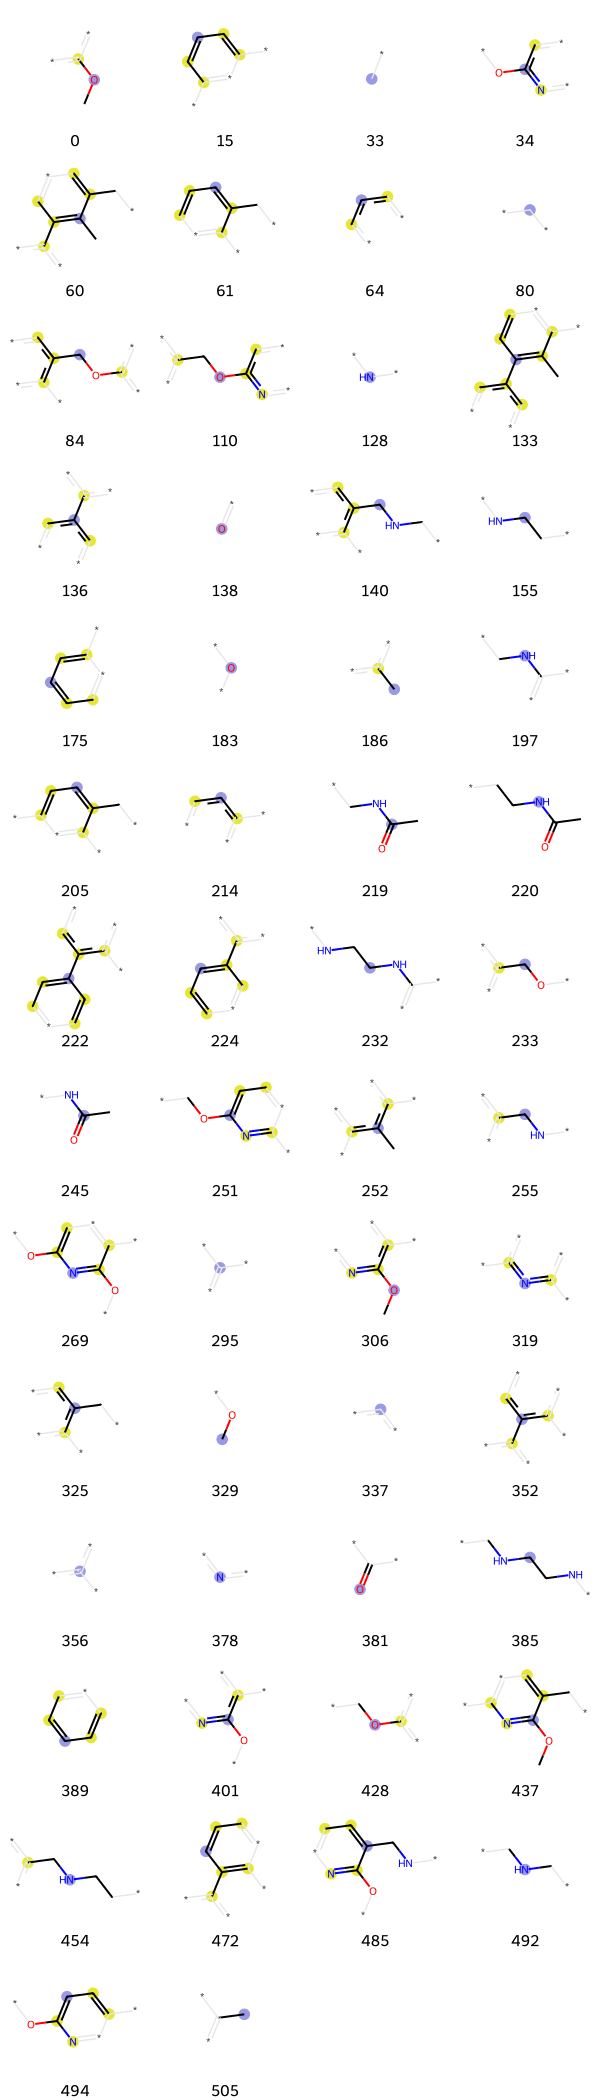

In [152]:
print("Visual semua fingerprint yang aktif pada Bits: ")
all_fragments = [(dataset.Structure[0], x, onbits) for x in morgan.GetOnBits()]
Draw.DrawMorganBits(all_fragments[:],molsPerRow=4, legends=[str(x) for x in morgan.GetOnBits()][:])

## RDkit

In [153]:
rdkbi = {}
RDkit = AllChem.RDKFingerprint(dataset.Structure[0], maxPath=5, fpSize=512, bitInfo=rdkbi)
print("Array bits: /n", np.array(RDkit))
print("Jumlah bits yang digunakan: ",len(RDkit))
print("Ukuran bits RDkit: ",np.array(RDkit).shape)
print("Index fingerprint yang aktif: \n",tuple(RDkit.GetOnBits()))
print("Jumlah fingerprint yang aktif: ",len(RDkit.GetOnBits()))

Array bits: /n [1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1
 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0
 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1
 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0
 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1
 1 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 0
 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0
 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0
 0 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0
 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1
 1 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1
 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 1 0
 1 1 1 0 0

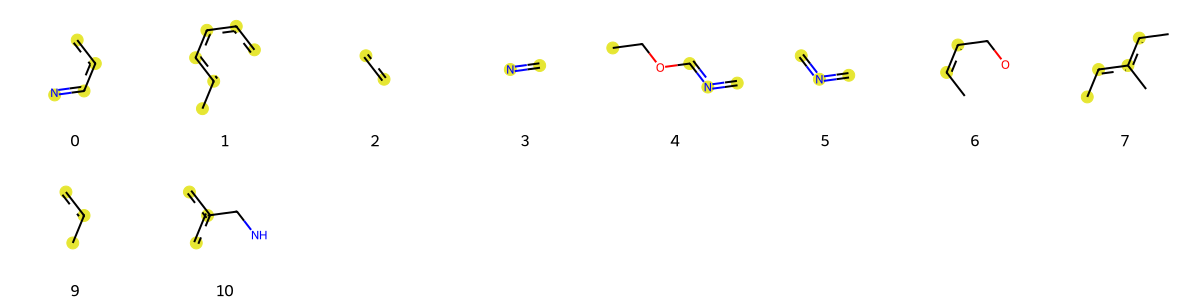

In [154]:
# Visualize more fragments
fragments = [(dataset.Structure[0], x, rdkbi) for x in rdkbi]
Draw.DrawRDKitBits(fragments[:10],molsPerRow=8,legends=[str(x) for x in rdkbi][:10])

# F. Data Engineering - Set all into function

In [155]:
# function definition
def generate_fpts(data): #, maxPath=5, fpSize=512, bitInfo=rdkbi):
    # create empty lists to store fingerprints

    # MACCS-keys fingerprint
    Mkeys = []

    # Morgan fingerprint
    Mfpts = []
    morBits ={}

    # Avalon fingerprint
    Avfpts = []

    # Topological Torsion fingerprint
    TT_fpts = []

    # Atom-Pair fingerprint
    APs = []

    # RDKit fingerprnt
    Rdk = []
    rdkBits = {}

    for mol in tqdm(data):
        # Calculation MACCS-keys fingerprints
        mkey = MACCSkeys.GenMACCSKeys(mol)
        Mkeys.append(mkey)

        # Calculate Morgan fingerprints and append to the empty list above
        mfpt = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048, bitInfo=morBits)
        Mfpts.append(mfpt)

        # Calculate Avalon fingerprints and append to the empty list above
        Avfpt = pyAvalonTools.GetAvalonFP(mol, nBits=2048)
        Avfpts.append(Avfpt)

        #calculate TopologicalTorsion fingerprints and append to the empty list above
        TT_fpt = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=2048)
        TT_fpts.append(TT_fpt)

        # Calculate Atom-Pair fingerprints
        ap = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=512)
        APs.append(ap)

        # Calculate RDKit fingerprint
        rdk = AllChem.RDKFingerprint(mol, maxPath=5, fpSize=512, bitInfo=rdkBits)
        Rdk.append(rdk)

    return np.array(Mkeys), np.array(Mfpts), np.array(Avfpts), np.array(TT_fpts), np.array(APs), np.array(Rdk), morBits, rdkBits

def output_results():
    print("MACCS-keys fingerprints: ", mkey.shape, ' --- ',"Number of On bits: ",np.count_nonzero(mkey), "\nMorgan fingerprints: ",mfpts.shape, ' --- ',"Number of On bits: ",np.count_nonzero(mfpts), "\nAvalon fingerprints: ", Avfpts.shape, ' --- ',"Number of On bits: ",np.count_nonzero(Avfpts), "\nTopological fingerprints: ",TT_fpts.shape, ' --- ',"Number of On bits: ",np.count_nonzero(TT_fpts), "\nATom Pair fingerprints: ", ap.shape, ' --- ',"Number of On bits: ",np.count_nonzero(ap), "\nRDKit fingerprints: ", rdk.shape, ' --- ',"Number of On bits: ",np.count_nonzero(rdk))

def fragment_Onbit(x): # x = mkey, mfpts, Avfpts, TT_fpts, ap, rdk
    print("Index of On bits:", np.nonzero(x))

In [156]:
# function call on structure
mkey, mfpts, Avfpts, TT_fpts, ap, rdk, morBits, rdkBits  = generate_fpts(dataset.Structure[:3])

# function call all structure
#mkey, mfpts, Avfpts, TT_fpts, ap, rdk, morBits, rdkBits  = generate_fpts(dataset.Structure[:len(dataset)])

100%|██████████| 3/3 [00:00<00:00, 163.43it/s]


In [157]:
output_results()

MACCS-keys fingerprints:  (3, 167)  ---  Number of On bits:  152 
Morgan fingerprints:  (3, 2048)  ---  Number of On bits:  181 
Avalon fingerprints:  (3, 2048)  ---  Number of On bits:  357 
Topological fingerprints:  (3, 2048)  ---  Number of On bits:  173 
ATom Pair fingerprints:  (3, 512)  ---  Number of On bits:  927 
RDKit fingerprints:  (3, 512)  ---  Number of On bits:  726


## Bits thats contribute to that structure on

In [158]:
fragment_Onbit(mfpts)

Index of On bits: (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2]), array([  60,   80,  197,  222,  245,  251,  252,  255,  352,  378,  389,
        401,  437,  596,  622,  650,  667,  695,  731,  736,  745,  807,
        841,  897,  984, 1004, 1017, 1039, 1057, 1088, 1152, 1160, 1199,
       1244, 1256, 1349, 1380, 1452, 1518, 1536, 1551, 1570, 1597, 1669,
       1676, 1722, 1741, 1750, 1805, 1842, 1855, 1873, 1917, 1990, 2021,
        

## Draw Morgan On Bit for single structure and single fingerprint

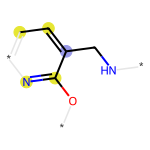

In [159]:
# Get the available bit IDs from the morBits dictionary
available_bit_ids = list(morBits.keys())

# Choose a bit ID that is present in the available_bit_ids
bit_id_to_draw = available_bit_ids[0]  # For example, choose the first available bit ID

# Draw the Morgan bit using the chosen bit ID
Draw.DrawMorganBit(dataset.Structure[0], bit_id_to_draw, morBits)

## Draw RDKit On Bit for single structure and single fingerprint

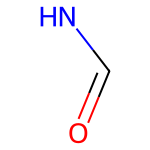

In [160]:
Draw.DrawRDKitBit(dataset.Structure[0],16,rdkBits)

# G. Tanimoto & Klustering

## 1. Mencari senyawa yang mirip dengan kueri atau senyawa tertentu

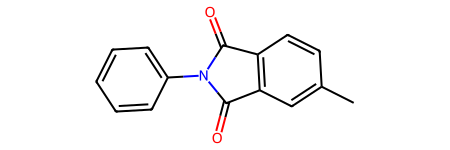

In [161]:
# Menghitung fingerprint untuk senyawa query
query = AllChem.MolFromSmiles('CC1=CC2=C(C=C1)C(=O)N(C2=O)C3=CC=CC=C3')
query_fps = AllChem.GetMorganFingerprintAsBitVect(query, 2, nBits=4096)
query

In [162]:
# Menghitung fingerprint seluruh dataset(total 4732)
all_Mfpts = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=4096) for mol in dataset.Structure]
len(all_Mfpts)

1020

In [163]:
# Menghitung Tanimoto coefficient dari senyawa query dan membandingkannya dengan tiap senyawa pad dataset
# Simpan semuanya di dalam list
# Tanimoto_similarity = [DataStructs.FingerprintSimilarity(query_fps, x, metric=DataStructs.TanimotoSimilarity) for x in all_] # Original line with error
Tanimoto_similarity = [DataStructs.FingerprintSimilarity(query_fps, x, metric=DataStructs.TanimotoSimilarity) for x in all_Mfpts]

In [164]:
# Menyimpan dataset kedalam variabel baru - agar tidak mengganggu dataset awal
dataset_sim = dataset

In [165]:
# Menambahkan kolom tanimoto_values pada dataset
dataset_sim["tanimoto_values"] = Tanimoto_similarity

In [166]:
# Mengurutkan dataset
dataset_sorted = dataset.sort_values(['tanimoto_values'],ascending=False)
dataset_sorted

,canonical_smiles,pIC50,Structure,tanimoto_values
687,Cc1c(-c2ccccc2)cccc1N1C(=O)c2ccc(OCc3ccccc3)cc...,5.00,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b6ce8f0>,0.37
700,Cc1c(-c2ccccc2)cccc1N1C(=O)c2ccc(CNCCO)cc2C1=O,6.47,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b6ceea0>,0.35
691,CC(=O)COc1ccc2c(c1)C(=O)N(c1cccc(-c3ccccc3)c1C...,5.98,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b6ceab0>,0.35
704,Cc1c(-c2ccccc2)cccc1N1C(=O)c2ccc(CNCCN)cc2C1=O,6.04,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b6cf060>,0.35
702,Cc1c(-c2ccccc2)cccc1N1C(=O)c2ccc(CN(C)CCO)cc2C1=O,6.04,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b6cef80>,0.35
...,...,...,...,...
1008,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)CN)C(=O)N[...,5.81,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b6d7680>,0.03
1006,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)CN)C(=O)N[...,5.36,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b6d75a0>,0.03
1012,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)CNC(=O)[C@...,4.72,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b6d7840>,0.03
1011,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)CNC(=O)[C@...,4.03,<rdkit.Chem.rdchem.Mol object at 0x7b6a4b6d77d0>,0.03


In [167]:
# Memfilter beradsarkan threshold tertentu
dataset_sorted[dataset_sorted['tanimoto_values'] >= 0.5]

,canonical_smiles,pIC50,Structure,tanimoto_values


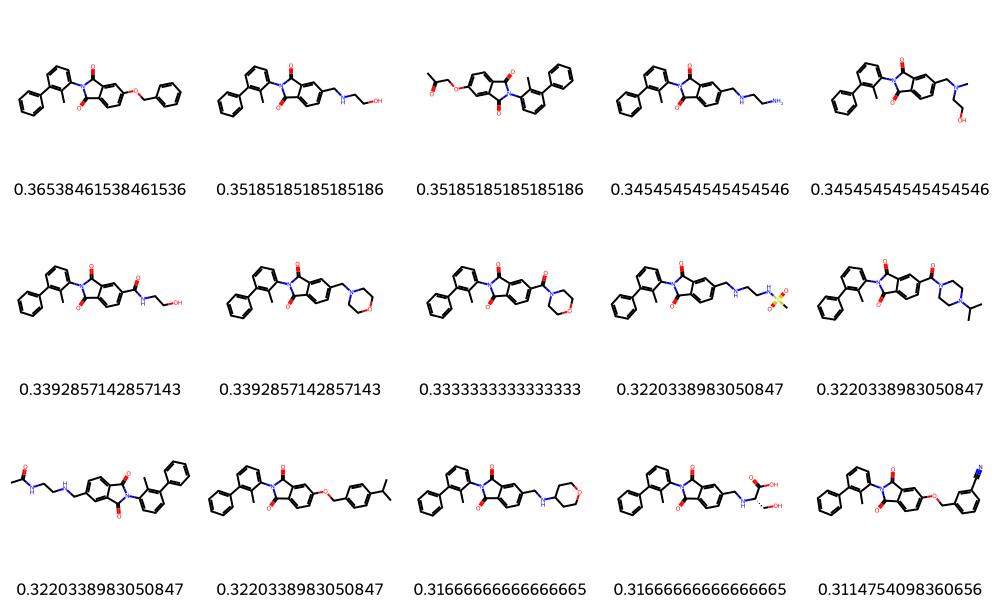

In [168]:
# Display structures and Tanimoto coefficient values
Draw.MolsToGridImage([x for x in dataset_sorted["Structure"]][:15], maxMols=100,
                     legends=[str(x) for x in dataset_sorted.tanimoto_values], subImgSize=(200,200), molsPerRow=5)

In [169]:
#--------------------------------------------------------
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.model_selection import ShuffleSplit, cross_validate,train_test_split
#--------------------------------------------------------
from lightgbm import LGBMRegressor

In [170]:
dataset = pd.read_csv('input_deskriptor.csv')
dataset.head()

,canonical_smiles,pIC50
0,COc1nc(OCc2cccc(-c3ccccc3)c2C)ccc1CNCCNC(C)=O,7.02
1,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1...,8.60
2,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...,8.66
3,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OC...,8.52
4,CCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OCc5cncc(...,8.42


In [171]:
dataset.shape

(1020, 2)

## Add kolom struktur kedalam dataset

In [172]:
# Include 2D structure of molecules
PandasTools.AddMoleculeColumnToFrame(dataset,'canonical_smiles','Stucture',includeFingerprints=True)

Failed to patch pandas - unable to change molecule rendering


In [173]:
dataset.head()

,canonical_smiles,pIC50,Stucture
0,COc1nc(OCc2cccc(-c3ccccc3)c2C)ccc1CNCCNC(C)=O,7.02,<rdkit.Chem.rdchem.Mol object at 0x7b6a5183b5a0>
1,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1...,8.60,<rdkit.Chem.rdchem.Mol object at 0x7b6a5183b610>
2,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...,8.66,<rdkit.Chem.rdchem.Mol object at 0x7b6a5183b4c0>
3,CC(=O)NCCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OC...,8.52,<rdkit.Chem.rdchem.Mol object at 0x7b6a5183b8b0>
4,CCNCc1cc(C)c(OCc2cccc(-c3cccc(COc4cc(OCc5cncc(...,8.42,<rdkit.Chem.rdchem.Mol object at 0x7b6a5183ba00>


In [174]:
def generate_AVfpts(data):

    # Store fingerprints using empty lists

    Avalon_fpts = []

    # Here no need to generate mol files
    # We can directly use the structure column of the data frame
    # mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(data):


        #=============================
        # calculate Avalon fingerprints
        #=============================
        avfpts = pyAvalonTools.GetAvalonFP(mol, nBits=4096)
        Avalon_fpts.append(avfpts)


    #=====append=========================
    # return the lists as numpy array
    #====================================
    return np.array(Avalon_fpts)

In [175]:
# Function call
Avalon_fpts = generate_AVfpts(dataset['Stucture'])

100%|██████████| 1020/1020 [00:03<00:00, 333.55it/s]


## Add seluruh kolom finger print kedalam dataset

In [176]:
# Put Avalon fingerprints into Dataframe
Avalon_fingerprints = pd.DataFrame(Avalon_fpts, columns=['Col_A_{}'.format(i + 1)
                                                        for i in range(Avalon_fpts.shape[1])])

Avalon_fingerprints.head()

,Col_A_1,Col_A_2,Col_A_3,Col_A_4,Col_A_5,Col_A_6,Col_A_7,Col_A_8,Col_A_9,Col_A_10,...,Col_A_4087,Col_A_4088,Col_A_4089,Col_A_4090,Col_A_4091,Col_A_4092,Col_A_4093,Col_A_4094,Col_A_4095,Col_A_4096
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
# Instantiate the models
lgbm_av = LGBMRegressor(n_estimators=800, random_state=42)
model_rf = RandomForestRegressor(random_state=42)

In [178]:
# start time
start = time.time()

# tenfold cross-validation
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
scoring = ['r2','neg_mean_absolute_error']

scores_val = cross_validate(lgbm_av, Avalon_fingerprints,  dataset.pIC50, scoring=scoring, cv=cv)

print(scores_val)

time.sleep(3)
# get the end time
end = time.time()

# get the execution time
total_time = end - start
print('Total time required:', round(total_time/60, 2), 'min')

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [179]:
# R^2 of coefficient of determination of tenfold cross validation
scores_val['test_r2']

array([0.58295087, 0.6871162 , 0.76194949, 0.68825264, 0.65732519,
       0.70341012, 0.58380247, 0.64721637, 0.63481455, 0.54827246])

In [180]:
# Mean absolute error (MAE) of the tenfold cross validation values
-scores_val['test_neg_mean_absolute_error']

array([0.53776457, 0.53073738, 0.46922061, 0.50837089, 0.50919925,
       0.53022429, 0.57995696, 0.50442211, 0.56385588, 0.53739235])

In [181]:
# Mean values of tenfold cross-validation values of R^2 and MAE
# Using lightGBM

print("R^2 :", round(np.mean(scores_val['test_r2']), 2))
print("MAE :", round(np.mean(-scores_val['test_neg_mean_absolute_error']), 2))

R^2 : 0.65
MAE : 0.53


## Menggunakan Train Test Split Avalon

In [182]:
X_train_av, X_test_av, y_train_av, y_test_av = train_test_split(Avalon_fingerprints,
                                                    dataset.pIC50,test_size=0.3,random_state=42)

In [ ]:
# Model training and test
model_av = lgbm_av.fit(X_train_av,y_train_av)
predict_av = model_av.predict(X_test_av)

In [184]:
# Model performance using MAE
MAE_av = mean_absolute_error(y_test_av, predict_av)
print('MAE:', round(MAE_av,2))

MAE: 0.54


In [185]:
# R^2 (coefficient of determination) regression score function:
R2_av =r2_score(y_test_av, predict_av)
print('R^2:', round(R2_av,2))

R^2: 0.58


In [186]:
import matplotlib.patches as mpatches

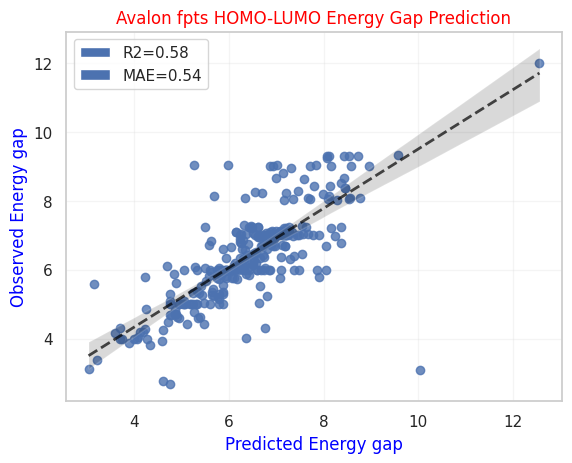

In [187]:
sns.regplot(x=predict_av, y=y_test_av,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy gap', color='blue')
plt.ylabel('Observed Energy gap', color ='blue')
plt.title("Avalon fpts HOMO-LUMO Energy Gap Prediction", color='red')
plt.grid(alpha=0.2)
R2_av = mpatches.Patch(label="R2={:04.2f}".format(R2_av))
MAE_av = mpatches.Patch(label="MAE={:04.2f}".format(MAE_av))
plt.legend(handles=[R2_av, MAE_av])